# Importing Required Modules

In [2]:
import os, sys
rmg_path = os.getenv('RMGpy')
if rmg_path and rmg_path not in sys.path:
    sys.path.insert(1,rmg_path)
import os
import re
import numpy as np
from collections import defaultdict, OrderedDict
import pandas as pd
from rmgpy.molecule import Molecule
from rmgpy.reaction import Reaction
import itertools
import IPython
from IPython.display import display, Markdown
def mprint(s): display(Markdown(s))
import cPickle as pickle
from graphviz import Digraph
# attempt at making the cells wider:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Function for Determing if Species is Reactant or Product

In [3]:
def isReactantOrProduct(self, reactant):
        """
        Checks to see if a certiant rmgpy.molecule object is in 
        either the reactants side or products side of rmgpy.reaction
        
        Inputs: 
        self (rmgpy.reaction)
        reactant (rmgpy.molecule)
        
        Output:
        result (bool) - True if reactant is in the reaction, Fasle if not.
        """
        
        if reactant in self.reactants:
            gotOne = True
        elif reactant in self.products:
            gotOne = True
        else: 
            gotOne = False
        return gotOne

# Overall bioTST Metering

In [14]:
directory = '/gss_gpfs_scratch/harms.n/bioTST/biofuels_rerun_Nov2'

# initiating dict
results = defaultdict(OrderedDict)


# creating blank list to store reactions that Did Not Finish
DNF = []

# TODO change this if possible

##########################################                      Number of Log Files is Hard Coded to 692

#
for i in range(1,693):
    r = results[i] 
    filename = 'AutoTST-biofuels.{0:d}.combined.log'.format(i)
    filepath = os.path.join(directory,filename)

    # reversing and making sure log file exists
    if os.path.exists(filepath):
        r['1 log file exists'] = 1
    else:
        continue
    
    # using with to open file, read contents, then close file
    with open(filepath) as f:
        lines = f.readlines()
    
    
    # using these bools to make the code more readable when if statements are needed later on
    # initializing to false for every reaction, not very elegant or pythonic
    A = False
    B = False
    C1 = False
    C2 = False
    D1 = False
    D2 = False
    E1 = False
    E2 = False
    F1 = False
    F2 = False
    G = False
    H = False
    I = False
    J1 = False
    J2 = False
    K = False
    L = False
    M = False
    M1 = False
    M2 = False
    N = False
    Y1 = False
    Y2 = False
    Z = False
        
    # j is iterator, while l is the line - enumerate splits these up
    for j,l in enumerate(lines):

        if re.match('biofuelsTST.py:191 performCalcs INFO chemkinRxn: (.*)', l):
            m = re.match('biofuelsTST.py:191 performCalcs INFO chemkinRxn: (.*)', l)
    
            rxn = eval(m.group(1))
            r['0 reaction'] = rxn
            
            # Method for finding fuel and abstractor from reactants and products by weight and if it is !!! radical !!!
            if rxn.reactants[0].getMolecularWeight() > rxn.reactants[1].getMolecularWeight():
                possible_fuel_r = rxn.reactants[0]
                possible_abstractor_r = rxn.reactants[1]
            else: 
                possible_fuel_r = rxn.reactants[1]
                possible_abstractor_r = rxn.reactants[0]

            if rxn.products[0].getMolecularWeight() > rxn.products[1].getMolecularWeight():
                possible_fuel_p = rxn.products[0]
                possible_abstractor_p = rxn.products[1]
            else: 
                possible_fuel_p = rxn.products[1]
                possible_abstractor_p = rxn.products[1]

            if possible_fuel_r.isRadical():
                fuel = possible_fuel_p
                abstractor = possible_abstractor_p
            else:
                fuel = possible_fuel_r
                abstractor = possible_abstractor_r
            
            r['0.1 fuel'] = fuel.toSMILES()
            r["0.2 abstractor"] = abstractor.toSMILES()
        
# adding checkpoints to r dict if they exist, allows creation of sankey diagram and more
        if 'We have generated a H_Abstraction reaction' in l:
            r['A: Matched H Abstraction'] = 1
            A = True
        
        if 'Calculating kinetic data' in l:
            r['B: Checked for Existing Kinetic File'] = 1
            B = True

        if 'Reading existing kinetics file' in l:
            r['C1: Kinetics File Already Exists'] = 1 # Reading in existing .kinetics file
            C1 = True       
        if 'Generating a TS geometry via the direct guess method' in l:
            r['C2: Needs New Kinetic File -> TS Direct Guess'] = 1
            C2 = True
        
        if 'exists. Loading it to save time' in l:
            r['D1: Found Existing TS File'] = 1
            D1 = True
        if 'TS estimate made. About to try the search' in l:
            r['D2: No Existing TS. Direct Guess Generated'] = 1
            D2 = True
            
        if 'Reading existing ts file' in l:
            r['E1: Reading Existing TS File'] = 1 # If reading in existing .ts file, this bypasses 4, 5 and 6
            E1 = True
            
        if 'Starting optimization steps of the TS search' in l:
            r['E2: Started TS Optimization Search'] = 1
            E2 = True

        if 'Optimizing TS attempt 1' in l:
            r['F1: TS Attempt 1'] = 1
            F1 = True
        if 'optimizeTS INFO Output file' in l and 'exists and looks complete. Trying that.' in l:
            r['F2: Previous TS optimization complete'] = 1
            F2 = True
            
        if 'Optimizing TS attempt 2' in l:
            r['G: TS Attempt 2'] = 1
            G = True
        
        if 'Optimizing TS attempt 1 but with quadratic scf' in l:
            r['H: TS Attempt 1 but with Quadratic SCF'] = 1
            H = True
        
        if 'Optimizing TS attempt 2 but with quadratic scf' in l:
            r['I: TS Attempt 2 but with Quadratic SCF'] = 1
            I = True
            
        if 'Saving TS result file' in l:
            r['J1: Saving Valid TS File'] = 1
            J1 = True
        if "Couldn't find transition state. Not using TST" in l:
            r['J2: Could Not Create Valid TS File'] = 1
            J2 = True
 
        if 'Symmetry input file written to' in l:
            r['K: Starting Symmetry Calculation'] = 1
            K = True
        
        if 'Point group:' in l:
            r['L: Symmetry Calculation Successful'] = 1
            L = True

        if 'CanTherm execution initiated' in l:
            r['M: CanTherm Started'] = 1
            M = True
        if 'Successful kinetics calculation in CanTherm' in l:
            r['M1: CanTherm Success'] = 1
            M1 = True
        if 'One or both of the barrier heights of' in l:
            r['M2: CanTherm Barrier Height Problem'] = 1
            M2 = True

        if 'Successful kinetics calculation in CanTherm' in l:
            r['N: CanTherm Success'] = 1
            N = True

        if 'Yay, reaction kinetics calculated' in l:
            r['Y1: Overall Success'] = 1
            Y1 = True           
        if "Boo, reaction kinetics not calculated" in l:
            r['Y2: Overall Fail'] = 1
            Y2 = True
        
    if Y1 or Y2:
        r['Z Complete'] = 1
        Z = True

    # used to see how many completions come from a certain point (A, B, C1,...)
    # Z = true when Complete
    # certain points are missing becuase they yield 0 because discovery does not have those log messages yet
    if Z and '1 log file exists' in r.keys():
        r['1 log file exists and Complete'] = 1
    if Z and A:
        r['A and Complete'] = 1
    if Z and B:
        r['B and Complete'] = 1
    if Z and C1:
        r['C1 and Complete'] = 1
    if Z and C2:
        r['C2 and Complete'] = 1
    if Z and D1:
        r['D1 and Complete'] = 1
    if Z and D2:
        r['D2 and Complete'] = 1
    if Z and E1:
        r['E1 and Complete'] = 1
    if Z and E2:
        r['E2 and Complete'] = 1
    if Z and F1:
        r['F1 and Complete'] = 1
    if Z and F2:
        r['F2 and Complete'] = 1
    if Z and G:
        r['G and Complete'] = 1
    if Z and J1:
        r['J1 and Complete'] = 1
    if Z and J2:
        r['J2 and Complete'] = 1
    if Z and K:
        r['K and Complete'] = 1
    if Z and L:
        r['L and Complete'] = 1
    if Z and M:
        r['M and Complete'] = 1
    if Z and M2:
        r['M2 and Complete'] = 1


    # used to find number of successes from a certain point
    # Y1 = True when successful
    if Y1 and '1 log file exists' in r.keys():
        r['1 log file exists and Success'] = 1
    if Y1 and A:
        r['A and Success'] = 1
    if Y1 and B:
        r['B and Success'] = 1
    if Y1 and C1:
        r['C1 and Success'] = 1
    if Y1 and C2:
        r['C2 and Success'] = 1
    if Y1 and D1:
        r['D1 and Success'] = 1
    if Y1 and D2:
        r['D2 and Success'] = 1
    if Y1 and E1:
        r['E1 and Success'] = 1
    if Y1 and E2:
        r['E2 and Success'] = 1
    if Y1 and F1:
        r['F1 and Success'] = 1
    if Y1 and F2:
        r['F2 and Success'] = 1
    if Y1 and G:
        r['G and Success'] = 1
    else:
        r['G and Success'] = np.nan
    if Y1 and J1:
        r['J1 and Success'] = 1
    if Y1 and J2:
        r['J2 and Success'] = 1
        print filename
    if Y1 and K:
        r['K and Success'] = 1
    if Y1 and L:
        r['L and Success'] = 1
    else:
        r['L and Success'] = np.nan # Needed because L is never succesful, but I want this key in the dictionary
    if Y1 and M:
        r['M and Success'] = 1
    if Y1 and M2:
        r['M2 and Success'] = 1
    else:
        r['M2 and Success'] = np.nan # Needed because L is never succesful, but I want this key in the dictionary
        
# creating pandas data frame (r.keys()as row titles)
dfsimple = pd.DataFrame(results)


# Useful Outputs
#dfsimple

dfsimple.count(axis = 1)
#len(DNF)

AutoTST-biofuels.476.combined.log
AutoTST-biofuels.486.combined.log


0 reaction                                       692
0.1 fuel                                         692
0.2 abstractor                                   692
1 log file exists                                692
1 log file exists and Complete                   653
1 log file exists and Success                    311
A and Complete                                   653
A and Success                                    311
A: Matched H Abstraction                         692
B and Complete                                   653
B and Success                                    311
B: Checked for Existing Kinetic File             692
C1 and Complete                                  263
C1 and Success                                   263
C1: Kinetics File Already Exists                 263
C2 and Complete                                  390
C2 and Success                                    48
C2: Needs New Kinetic File -> TS Direct Guess    429
D1 and Complete                               

In [11]:
# getting numbers for flowchart (see 'Simplified df for flowchart')
dfsimple_summary = dfsimple.count(axis=1)
dfsimple_summary

#TODO make method so if category is zero, key still exists so no error (F2 and success)
start_count = dfsimple_summary['1 log file exists']
start_succ = dfsimple_summary['1 log file exists and Success']
start_comp = dfsimple_summary['1 log file exists and Complete']

A_count = dfsimple_summary['A: Matched H Abstraction']
A_succ = dfsimple_summary['A and Success']
A_comp = dfsimple_summary['A and Complete']

not_OOH = start_count - A_count

B_count = dfsimple_summary['B: Checked for Existing Kinetic File']
B_succ = dfsimple_summary['B and Success']
B_comp = dfsimple_summary['B and Complete']

C1_count = dfsimple_summary['C1: Kinetics File Already Exists']
C1_comp = dfsimple_summary['C1 and Complete']
C1_succ = dfsimple_summary['C1 and Success']

C2_count = dfsimple_summary['C2: Needs New Kinetic File -> TS Direct Guess']
C2_comp = dfsimple_summary['C2 and Complete']
C2_succ = dfsimple_summary['C2 and Success']

D1_count = dfsimple_summary['D1: Found Existing TS File']
D1_comp = dfsimple_summary['D1 and Complete']
D1_succ = dfsimple_summary['D1 and Success']

D2_count = dfsimple_summary['D2: No Existing TS. Direct Guess Generated']
D2_comp = dfsimple_summary['D2 and Complete']
D2_succ = dfsimple_summary['D2 and Success']

C1_to_D1_D2_DNF = C2_count - (D1_count + D2_count)

E1_count = dfsimple_summary['E1: Reading Existing TS File']
E1_comp = dfsimple_summary['E1 and Complete']
E1_succ = dfsimple_summary['E1 and Success']

E2_count = dfsimple_summary['E2: Started TS Optimization Search']
E2_comp = dfsimple_summary['E2 and Complete']
E2_succ = dfsimple_summary['E2 and Success']

F1_count = dfsimple_summary['F1: TS Attempt 1']
F1_comp = dfsimple_summary['F1 and Complete']
F1_succ = dfsimple_summary['F1 and Success']

#TODO fix no key problem if count is zero
F2_count = dfsimple_summary['F2: Previous TS optimization complete']
F2_comp = dfsimple_summary['F2 and Complete']
F2_succ = dfsimple_summary['F2 and Success']

E2_to_F1_F2_DNF = E2_count - (F1_count + F2_count)

G_count = dfsimple_summary['G: TS Attempt 2']
G_comp = dfsimple_summary['G and Complete']
G_succ = dfsimple_summary['G and Success']

J1_count = dfsimple_summary['J1: Saving Valid TS File']
J1_comp = dfsimple_summary['J1 and Complete']
J1_succ = dfsimple_summary['J1 and Success']

#TODO uncomment when fixed
J2_count = dfsimple_summary['J2: Could Not Create Valid TS File']
J2_comp = dfsimple_summary['J2 and Complete']
J2_succ = dfsimple_summary['J2 and Success']

F1_F2_to_J1_J2_DNF = (F1_count + F2_count) - (J1_count + J2_count)

K_count = dfsimple_summary['K: Starting Symmetry Calculation']
K_comp = dfsimple_summary['K and Complete']
K_succ = dfsimple_summary['K and Success']

E1_J1_to_K_DNF = (E1_count + J1_count) - K_count

L_count = dfsimple_summary['L: Symmetry Calculation Successful']
L_comp = dfsimple_summary['L and Complete']
L_succ = dfsimple_summary['L and Success']

K_to_L_DNF = K_count - L_count

M_count = dfsimple_summary['M: CanTherm Started']
M_comp = dfsimple_summary['M and Complete']
M_succ = dfsimple_summary['M and Success']

L_to_M_DNF = L_count - M_count

M_to_Y1_Y2_DNF = M_count - M_comp

M2_count = dfsimple_summary['M2: CanTherm Barrier Height Problem']
M2_comp = dfsimple_summary['M2 and Complete']
M2_succ = dfsimple_summary['M2 and Success']

overall_success = dfsimple_summary['Y1: Overall Success']
overall_failure = dfsimple_summary['Y2: Overall Fail']
overall_complete = dfsimple_summary['Z Complete']

overall_DNF = A_count - (overall_success + overall_failure)

print 'done'

done


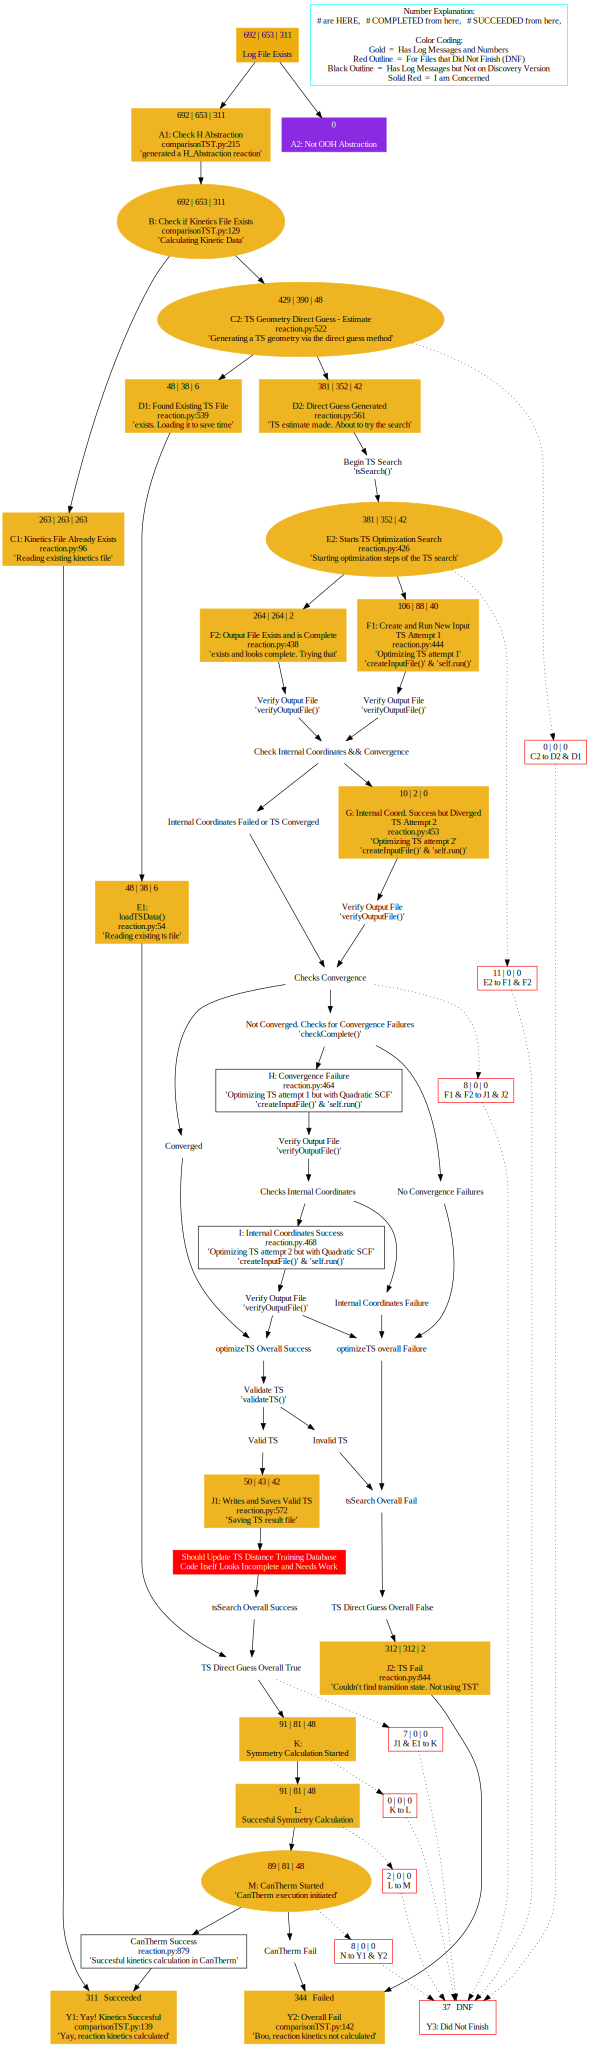

In [12]:
flowchart = None
flowchart = Digraph('comparisonTST', filename = 'comparisonTSTflowchart.gv')
#TODO test
#TODO make numbers automatic

# Default attributes of node
flowchart.attr('node', color = 'white', fontcolor = 'black', shape = 'rectangle', style = 'filled')

flowchart.node('start', color = 'darkgoldenrod2', fontcolor = 'navy', label = "{} | {} | {}\n\nLog File Exists".format(start_count, start_comp, start_succ), shape = 'box')

flowchart.node('matchH', label = "{} | {} | {}\n\nA1: Check H Abstraction\ncomparisonTST.py:215\n'generated a H_Abstraction reaction'".format(A_count, A_comp, A_succ), color = 'goldenrod2')
flowchart.node('notOOHabstraction', label = "{}\n\nA2: Not OOH Abstraction".format(not_OOH), color = 'blueviolet', fontcolor = 'white')

flowchart.node('checkKin', label = "{} | {} | {}\n\nB: Check if Kinetics File Exists\ncomparisonTST.py:129\n'Calculating Kinetic Data'".format(B_count, B_comp, B_succ), shape = 'ellipse', color = 'goldenrod2')

flowchart.node('checkKin_Exists', label = "{} | {} | {}\n\nC1: Kinetics File Already Exists\nreaction.py:96\n'Reading existing kinetics file'".format(C1_count, C1_comp, C1_succ), color = 'goldenrod2')

flowchart.node('TSdirect', label = "{} | {} | {}\n\nC2: TS Geometry Direct Guess - Estimate\nreaction.py:522\n'Generating a TS geometry via the direct guess method'".format(C2_count, C2_comp, C2_succ), shape = 'ellipse', color = 'goldenrod2')
flowchart.node('TSdirect_exists', label = "{} | {} | {}\n\nD1: Found Existing TS File\nreaction.py:539\n'exists. Loading it to save time'".format(D1_count, D1_comp, D1_succ), color = 'goldenrod2')
flowchart.node('loadTSData', label = "{} | {} | {}\n\nE1:\nloadTSData()\nreaction.py:54\n'Reading existing ts file'".format(E1_count, E1_comp, E1_succ), color = 'goldenrod2')

flowchart.node('TSdirect_generated', label = "{} | {} | {}\n\nD2: Direct Guess Generated\nreaction.py:561\n'TS estimate made. About to try the search'".format(D2_count, D2_comp, D2_succ), color = 'goldenrod2')

flowchart.node('tsSearch', label = "Begin TS Search\n'tsSearch()'")
flowchart.node('tsSearch_overallSuccess', label = "tsSearch Overall Success")
flowchart.node('tsSearch_overallFail', label = "tsSearch Overall Fail")
#####
flowchart.node('validateTS', label = "Validate TS\n'validateTS()'")
flowchart.node('validateTS_valid', label = "Valid TS")
flowchart.node('validateTS_invalid', label = "Invalid TS")
flowchart.node('validateTS_valid_writeAndSave', label = "{} | {} | {}\n\nJ1: Writes and Saves Valid TS\nreaction.py:572\n'Saving TS result file'".format(J1_count, J1_comp, J1_succ), color = 'goldenrod2')
#####
flowchart.node('TSdirect_overallFalse', label = "TS Direct Guess Overall False")
flowchart.node('TSdirect_overallTrue', label = "TS Direct Guess Overall True")

flowchart.node('Updates_TSdist_training_database', label = "Should Update TS Distance Training Database\nCode Itself Looks Incomplete and Needs Work", color = 'red', fontcolor = 'white')
#####
flowchart.node('optimizeTS', label = "{} | {} | {}\n\nE2: Starts TS Optimization Search\nreaction.py:426\n'Starting optimization steps of the TS search'".format(E2_count, E2_comp, E2_succ), shape = 'ellipse', color = 'goldenrod2')

flowchart.node('optimizeTS_outputAlreadyExists_complete', label = "{} | {} | {}\n\nF2: Output File Exists and is Complete\nreaction.py:438\n'exists and looks complete. Trying that'".format(F2_count, F2_comp, F2_succ), color = 'goldenrod2')
flowchart.node('optimizeTS_outputAlreadyExists_complete_verify', label = "Verify Output File\n'verifyOutputFile()'")
flowchart.node('optimizeTS_outputDNE_newInput', label = "{} | {} | {}\n\nF1: Create and Run New Input\nTS Attempt 1\nreaction.py:444\n'Optimizing TS attempt 1'\n'createInputFile()' & 'self.run()'".format(F1_count, F1_comp, F1_succ), color = 'goldenrod2')
flowchart.node('optimizeTS_outputDNE_newInput_VOF', label = "Verify Output File\n'verifyOutputFile()'")
flowchart.node('optimizeTS_checkIntCoord', label = "Check Internal Coordinates && Convergence", shape = 'ellipse')
flowchart.node('optimizeTS_checkIntCoord_Conv', label ="Internal Coordinates Failed or TS Converged")
flowchart.node('optimizeTS_checkIntCoord_DNC', label = "{} | {} | {}\n\nG: Internal Coord. Success but Diverged\nTS Attempt 2\nreaction.py:453\n'Optimizing TS attempt 2'\n'createInputFile()' & 'self.run()'".format(G_count, G_comp, G_succ), color = 'goldenrod2')
flowchart.node('optimizeTS_checkIntCoord_DNC_VOF', label = "Verify Output File\n'verifyOutputFile()'")
flowchart.node('optimizeTS_checkConv', label = "Checks Convergence", shape = 'ellipse')
flowchart.node('optimizeTS_checkConv_converged', label = "Converged")
flowchart.node('optimizeTS_checkConv_DNC', label = "Not Converged. Checks for Convergence Failures\n'checkComplete()'", shape = 'ellipse')
flowchart.node('optimizeTS_checkConv_DNC_convFailure', label = "H: Convergence Failure\nreaction.py:464\n'Optimizing TS attempt 1 but with Quadratic SCF'\n'createInputFile()' & 'self.run()'", color = 'black', style = 'solid')
flowchart.node('optimizeTS_checkConv_DNC_convFailure_VOF', label = "Verify Output File\n'verifyOutputFile()'")
flowchart.node('optimizeTS_checkConv_DNC_convFailure_checkIntCoord', label = "Checks Internal Coordinates", shape = 'ellipse')
flowchart.node('optimizeTS_checkConv_DNC_convSuccess', label = "No Convergence Failures")
flowchart.node('optimizeTS_checkConv_DNC_convFailure_checkIntCoord_ICsucc', label = "I: Internal Coordinates Success\nreaction.py.468\n'Optimizing TS attempt 2 but with Quadratic SCF'\n'createInputFile()' & 'self.run()'", color = 'black', style = 'solid')
flowchart.node('optimizeTS_checkConv_DNC_convFailure_checkIntCoord_ICsucc_VOF', label = "Verify Output File\n'verifyOutputFile()'")
flowchart.node('optimizeTS_checkConv_DNC_convFailure_checkIntCoord_ICfail', label = "Internal Coordinates Failure")

flowchart.node('optimizeTS_overallSuccess', label = "optimizeTS Overall Success")
flowchart.node('optimizeTS_overallFail', label = "optimizeTS overall Failure")
#####
flowchart.node('symmetry_start', label = "{} | {} | {}\n\nK:\nSymmetry Calculation Started".format(K_count, K_comp, K_succ), color = 'goldenrod2')
flowchart.node('symmetry_success', label = "{} | {} | {}\n\nL:\nSuccesful Symmetry Calculation".format(L_count, L_comp, L_succ), color = 'goldenrod2')

flowchart.node('canTherm', label = "{} | {} | {}\n\nM: CanTherm Started\n'CanTherm execution initiated'".format(M_count, M_comp, M_succ), shape = 'ellipse', color = 'goldenrod2')
flowchart.node('canTherm_fail', label = "CanTherm Fail")
flowchart.node('canTherm_success', label = "CanTherm Success\nreaction.py:879\n'Succesful kinetics calculation in CanTherm'", color = 'black', style = 'solid')

flowchart.node('TSoverallFail', label = "{} | {} | {}\n\nJ2: TS Fail\nreaction.py:844\n'Couldn't find transition state. Not using TST'".format(J2_count, J2_comp, J2_succ), color = 'goldenrod2')
flowchart.node('overallFail', label = "{}   Failed\n\nY2: Overall Fail\ncomparisonTST.py:142\n'Boo, reaction kinetics not calculated'".format(overall_failure), color = 'goldenrod2')
flowchart.node('overallSuccess', label = "{}   Succeeded\n\nY1: Yay! Kinetics Succesful\ncomparisonTST.py:139\n'Yay, reaction kinetics calculated'".format(overall_success), color = 'goldenrod2')

# DNF nodes
flowchart.node('TSdirect_DNF', label = "{} | 0 | 0\nC2 to D2 & D1".format(C1_to_D1_D2_DNF), color = 'red', style = 'solid')
flowchart.node('optimizeTS_DNF', label = "{} | 0 | 0\nE2 to F1 & F2".format(E2_to_F1_F2_DNF), color = 'red', style = 'solid')
flowchart.node('optimizeTS_checkConv_DNF', label = "{} | 0 | 0\nF1 & F2 to J1 & J2".format(F1_F2_to_J1_J2_DNF), color = 'red', style = 'solid')
flowchart.node('TSdirect_overallTrue_DNF', label = "{} | 0 | 0\nJ1 & E1 to K".format(E1_J1_to_K_DNF), color = 'red', style = 'solid')
flowchart.node('symmetry_start_DNF', label = '{} | 0 | 0\nK to L'.format(K_to_L_DNF),color = 'red', style = 'solid')
flowchart.node('symmetry_success_DNF', label = '{} | 0 | 0\nL to M'.format(L_to_M_DNF),color = 'red', style = 'solid')
flowchart.node('canTherm_DNF', label = "{} | 0 | 0\nN to Y1 & Y2".format(M_to_Y1_Y2_DNF), color = 'red', style = 'solid')
flowchart.node('overallDNF', label = "{}   DNF\n\nY3: Did Not Finish".format(overall_DNF), color = 'red', style = 'solid')

# Legend node
flowchart.node('Legend', label = "Number Explanation:\n# are HERE,   # COMPLETED from here,   # SUCCEEDED from here,\n\nColor Coding:\nGold  =  Has Log Messages and Numbers\nRed Outline  =  For Files that Did Not Finish (DNF)\nBlack Outline  =  Has Log Messages but Not on Discovery Version\nSolid Red  =  I am Concerned", color = 'cyan', style = 'solid')

flowchart.edge('start', 'matchH')
flowchart.edge('matchH', 'checkKin')
flowchart.edge('start', 'notOOHabstraction')
flowchart.edge('checkKin', 'checkKin_Exists')
flowchart.edge('checkKin_Exists', 'overallSuccess')
flowchart.edge('checkKin', 'TSdirect')
flowchart.edge('TSdirect', 'TSdirect_DNF', style = 'dotted')
flowchart.edge('TSdirect_DNF', 'overallDNF', style = 'dotted')
flowchart.edge('TSdirect', 'TSdirect_exists')
flowchart.edge('TSdirect_exists', 'loadTSData')
flowchart.edge('loadTSData', 'TSdirect_overallTrue')
flowchart.edge('TSdirect', 'TSdirect_generated')
flowchart.edge('TSdirect_generated', 'tsSearch')
flowchart.edge('tsSearch', 'optimizeTS')
flowchart.edge('optimizeTS', 'optimizeTS_DNF', style = 'dotted')
flowchart.edge('optimizeTS_DNF', 'overallDNF', style = 'dotted')
flowchart.edge('optimizeTS', 'optimizeTS_outputDNE_newInput')
flowchart.edge('optimizeTS_outputDNE_newInput', 'optimizeTS_outputDNE_newInput_VOF')
flowchart.edge('optimizeTS_outputDNE_newInput_VOF', 'optimizeTS_checkIntCoord')
flowchart.edge('optimizeTS', 'optimizeTS_outputAlreadyExists_complete')
flowchart.edge('optimizeTS_outputAlreadyExists_complete', 'optimizeTS_outputAlreadyExists_complete_verify')
flowchart.edge('optimizeTS_outputAlreadyExists_complete_verify', 'optimizeTS_checkIntCoord')
flowchart.edge('optimizeTS_checkIntCoord', 'optimizeTS_checkIntCoord_DNC')
flowchart.edge('optimizeTS_checkIntCoord_DNC', 'optimizeTS_checkIntCoord_DNC_VOF')
flowchart.edge('optimizeTS_checkIntCoord_DNC_VOF', 'optimizeTS_checkConv')
flowchart.edge('optimizeTS_checkIntCoord', 'optimizeTS_checkIntCoord_Conv')
flowchart.edge('optimizeTS_checkIntCoord_Conv', 'optimizeTS_checkConv')
flowchart.edge('optimizeTS_checkConv', 'optimizeTS_checkConv_DNF', style = 'dotted')
flowchart.edge('optimizeTS_checkConv_DNF', 'overallDNF', style = 'dotted')
flowchart.edge('optimizeTS_checkConv', 'optimizeTS_checkConv_converged')
flowchart.edge('optimizeTS_checkConv', 'optimizeTS_checkConv_DNC')
flowchart.edge('optimizeTS_checkConv_DNC', 'optimizeTS_checkConv_DNC_convFailure')
flowchart.edge('optimizeTS_checkConv_DNC_convFailure', 'optimizeTS_checkConv_DNC_convFailure_VOF')
flowchart.edge('optimizeTS_checkConv_DNC', 'optimizeTS_checkConv_DNC_convSuccess')
flowchart.edge('optimizeTS_checkConv_DNC_convFailure_VOF', 'optimizeTS_checkConv_DNC_convFailure_checkIntCoord')
flowchart.edge('optimizeTS_checkConv_DNC_convFailure_checkIntCoord', 'optimizeTS_checkConv_DNC_convFailure_checkIntCoord_ICsucc')
flowchart.edge('optimizeTS_checkConv_DNC_convFailure_checkIntCoord', 'optimizeTS_checkConv_DNC_convFailure_checkIntCoord_ICfail')
flowchart.edge('optimizeTS_checkConv_DNC_convFailure_checkIntCoord_ICsucc', 'optimizeTS_checkConv_DNC_convFailure_checkIntCoord_ICsucc_VOF')
flowchart.edge('optimizeTS_checkConv_converged', 'optimizeTS_overallSuccess')
flowchart.edge('optimizeTS_checkConv_DNC_convFailure_checkIntCoord_ICsucc_VOF', 'optimizeTS_overallSuccess')
flowchart.edge('optimizeTS_checkConv_DNC_convFailure_checkIntCoord_ICsucc_VOF', 'optimizeTS_overallFail')
flowchart.edge('optimizeTS_checkConv_DNC_convSuccess', 'optimizeTS_overallFail')
flowchart.edge('optimizeTS_checkConv_DNC_convFailure_checkIntCoord_ICfail', 'optimizeTS_overallFail')
flowchart.edge('optimizeTS_overallFail', 'tsSearch_overallFail')
flowchart.edge('optimizeTS_overallSuccess', 'validateTS')
flowchart.edge('validateTS', 'validateTS_valid')
flowchart.edge('validateTS', 'validateTS_invalid')
flowchart.edge('validateTS_valid', 'validateTS_valid_writeAndSave')
flowchart.edge('validateTS_valid_writeAndSave', 'Updates_TSdist_training_database')
flowchart.edge('Updates_TSdist_training_database', 'tsSearch_overallSuccess')
flowchart.edge('tsSearch_overallSuccess', 'TSdirect_overallTrue')

flowchart.edge('TSdirect_overallTrue', 'symmetry_start')
flowchart.edge('symmetry_start', 'symmetry_success')
flowchart.edge('symmetry_start', 'symmetry_start_DNF', style = 'dotted')
flowchart.edge('symmetry_start_DNF', 'overallDNF', style = 'dotted')
flowchart.edge('symmetry_success', 'canTherm')
flowchart.edge('symmetry_success', 'symmetry_success_DNF', style = 'dotted')
flowchart.edge('symmetry_success_DNF', 'overallDNF', style = 'dotted')
#flowchart.edge('TSdirect_overallTrue', 'canTherm')

flowchart.edge('TSdirect_overallTrue', 'TSdirect_overallTrue_DNF', style = 'dotted')
flowchart.edge('TSdirect_overallTrue_DNF', 'overallDNF', style = 'dotted')
flowchart.edge('validateTS_invalid', 'tsSearch_overallFail')
flowchart.edge('tsSearch_overallFail', 'TSdirect_overallFalse')
flowchart.edge('TSdirect_overallFalse', 'TSoverallFail')
flowchart.edge('TSoverallFail', 'overallFail')
flowchart.edge('canTherm', 'canTherm_success')
flowchart.edge('canTherm_success', 'overallSuccess')
flowchart.edge('canTherm', 'canTherm_fail')
flowchart.edge('canTherm_fail', 'overallFail')
flowchart.edge('canTherm', 'canTherm_DNF', style = 'dotted')
flowchart.edge('canTherm_DNF', 'overallDNF', style = 'dotted')

flowchart

# Sorting by Fuels and Abstractors

## Fuel Summary:

In [98]:
"""

-Each Fuel Should have a df of all its relavent reactions

-A summary df of can be made by summing the first df about it's rows

-These summaries can be used to create a df, where all the summaries are organied by fuel


"""

df_list = [] #empty list for concating summary dfs

for fuel in dfsimple.T['0.1 fuel'].unique(): # iterating through unique fuels in df
    append_df = dfsimple.T[dfsimple.T["0.1 fuel"] == fuel].T.count(axis = 1) # getting individual summary df for fuel
    
    append_df.name = fuel # naming df for fuel
    
    # getting some data to calculat relavent completion or success rates
    exists_count = append_df['1 log file exists']
    complete_count = append_df['1 log file exists and Complete']
    success_count = append_df['1 log file exists and Success']
    
    # adding those simple stats to summary df
    append_df['-1: Completion Percentage'] = round(100.0 * complete_count / exists_count, 1)
    append_df['-1.1: Success Percentage'] = round(100.0 * success_count / exists_count, 1)
    df_list.append(append_df) #TODO maybe rename things, fix method to get rid of append if possible

fuel_df = pd.concat(df_list, axis = 1) # concating all summary dfs into one df
fuel_df

,OO,[O]O,[O][O],CC(C)CC(C)(C)C,CCC(C)CC(C)C,CCCCC(C)CC,CCC(C)(C)O,CCCC(C)CO,CCCC(C)C=C(C)C,CC1CCCC1,...,CCCCCC1CCC(C)O1,CCCCC=C(C)C,CCCC=CC(C)C,CCC=CCC(C)C,CC=CCCC(C)C,C=CCCCC(C)C,O,[O],C,[CH3]
0 reaction,6.0,3.0,1.0,20.0,35.0,40.0,20.0,35.0,35.0,20.0,...,50.0,30.0,35.0,35.0,35.0,35.0,2.0,2.0,2.0,1.0
0.1 fuel,6.0,3.0,1.0,20.0,35.0,40.0,20.0,35.0,35.0,20.0,...,50.0,30.0,35.0,35.0,35.0,35.0,2.0,2.0,2.0,1.0
0.2 abstractor,6.0,3.0,1.0,20.0,35.0,40.0,20.0,35.0,35.0,20.0,...,50.0,30.0,35.0,35.0,35.0,35.0,2.0,2.0,2.0,1.0
1 log file exists,6.0,3.0,1.0,20.0,35.0,40.0,20.0,35.0,35.0,20.0,...,50.0,30.0,35.0,35.0,35.0,35.0,2.0,2.0,2.0,1.0
1 log file exists and Complete,6.0,3.0,1.0,18.0,35.0,40.0,20.0,35.0,33.0,20.0,...,45.0,22.0,30.0,28.0,28.0,30.0,2.0,2.0,2.0,1.0
1 log file exists and Success,2.0,0.0,0.0,9.0,23.0,24.0,13.0,20.0,10.0,12.0,...,23.0,10.0,13.0,10.0,13.0,16.0,0.0,2.0,1.0,0.0
C1 and Complete,2.0,0.0,0.0,8.0,20.0,20.0,11.0,17.0,9.0,12.0,...,22.0,10.0,13.0,10.0,12.0,16.0,0.0,2.0,1.0,0.0
C1 and Success,2.0,0.0,0.0,8.0,20.0,20.0,11.0,17.0,9.0,12.0,...,22.0,10.0,13.0,10.0,12.0,16.0,0.0,2.0,1.0,0.0
C1: Kinetics File Already Exists,2.0,0.0,0.0,8.0,20.0,20.0,11.0,17.0,9.0,12.0,...,22.0,10.0,13.0,10.0,12.0,16.0,0.0,2.0,1.0,0.0
C2 and Complete,4.0,3.0,1.0,10.0,15.0,20.0,9.0,18.0,24.0,8.0,...,23.0,12.0,17.0,18.0,16.0,14.0,2.0,0.0,1.0,1.0


## Sorting the ten least succesful fuels

In [97]:
fuel_df.T.iloc[:,-2:].sort_values(by='-1.1: Success Percentage').head(10)

,-1: Completion Percentage,-1.1: Success Percentage
[CH3],100.0,0.0
[O]O,100.0,0.0
[O][O],100.0,0.0
O,100.0,0.0
CC(C)(C)OCC(CO)OC(C)(C)C,83.3,23.3
CCC=CCC(C)C,80.0,28.6
CCCC(C)C=C(C)C,94.3,28.6
CC1=CCC2CC1C2(C)C,82.9,31.4
C=CC(C)=CCCC(=C)C,97.5,32.5
OO,100.0,33.3


## The Ten Fuels with the Lowest Completion Percentages

In [95]:
fuel_df.T.iloc[:,-2:].sort_values(by='-1: Completion Percentage').head(10)

,-1: Completion Percentage,-1.1: Success Percentage
CCCCC=C(C)C,73.3,33.3
CCC=CCC(C)C,80.0,28.6
CC=CCCC(C)C,80.0,37.1
CC1=CCC2CC1C2(C)C,82.9,31.4
CC(C)(C)OCC(CO)OC(C)(C)C,83.3,23.3
CC1=CCCC1=O,85.0,55.0
CCCC=CC(C)C,85.7,37.1
C=CCCCC(C)C,85.7,45.7
CC(C)CC(C)(C)C,90.0,45.0
CCCCCC1CCC(C)O1,90.0,46.0


# Summary of Abstractors

In [94]:
abstractor_df = pd.DataFrame()
df_list = []
for abstractor in dfsimple.T['0.2 abstractor'].unique():
    append_df = dfsimple.T[dfsimple.T["0.2 abstractor"] == abstractor].T.count(axis = 1)
    append_df.name = abstractor
    
    exists_count = append_df['1 log file exists']
    complete_count = append_df['1 log file exists and Complete']
    success_count = append_df['1 log file exists and Success']

    append_df['-1: Completion Percentage'] = round(100.0 * complete_count / exists_count, 1)
    append_df['-1.1: Success Percentage'] = round(100.0 * success_count / exists_count, 1)
    append_df['-1.2: Completed over Successful'] = round(100.0 * success_count / complete_count, 1)
    df_list.append(append_df) #TODO comment this section, delete old attempt, fix method to get rid of append if possible

abstractor_df = pd.concat(df_list, axis = 1)
abstractor_df.tail(3)

,[O],[O][O],[OH],[H],[CH3],[CH2],[O]O
-1: Completion Percentage,97.1,100.0,99.3,94.9,67.9,100.0,99.3
-1.1: Success Percentage,9.3,0.0,29.9,82.6,47.4,33.3,47.4
-1.2: Completed over Successful,9.6,0.0,30.1,87.0,69.9,33.3,47.8
